## Visualisation of excess mortality over Europe in 2020 using _Eurostat_ data

The purpose of this notebook is to dynamically generate maps of weekly excess mortality over Europe NUTS2 or NUTS3 regions, depending on their availability.

Data source: 

* _Eurostat_ data on _"Deaths by age group, sex, week and NUTS 3 region"_ [demo_r_mweek3](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=demo_r_mweek3&lang=en),
* _Eurostat_ geographical data on regional units NUTS 2016 (see [GISCO website](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts)).

Notes:

* We provide here with some quick and dirty material to fetch the data from the provider (*e.g.*, in a bulk manner, not using the API) and compute basic descriptive statistics (*e.g.*, an excess rate). This will need to be improved in order to further automate it.
* This notebook was created on May 13th, 2020. Therefore, the results presented here refer to the data extracted from _Eurostat_ website at that date.

### Setting

Let's import all we need:

In [1]:
THISDIR = !pwd

import requests
import io, os, re
import zipfile

In [2]:
import pandas as pd
import numpy as np

In [3]:
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")

In [4]:
try:
    import matplotlib
except ImportError:
    raise IOError("Guess what: you're doomed...")
else:
    import matplotlib.pyplot as mplt
    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter, MaxNLocator, IndexLocator
finally:
    _FIGSIZE_, _DPI_ = (7,4), 140 # just some default display size/resolution inside this notebook...
%matplotlib inline

### (Dirty) data ingestion

Data on death figures will be fetched from [Eurostat bulk website](https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&dir=data). The link to the data source in TSV format is : https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_r_mweek3.tsv.gz. 

In [5]:
bulk_domain = 'https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1'
death_file = 'demo_r_mweek3'
death_ext = 'tsv.gz'
death_url = '{}&file=data%2F{}.{}'.format(bulk_domain, death_file, death_ext)
print("URL for death data: \033[1m%s\033[0m" % death_url)

URL for death data: https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_r_mweek3.tsv.gz


In [6]:
death_source = '%s.%s' % (death_file, death_ext)
try:
    !wget -O $death_source "$death_url"
    !gunzip -f $death_source
except:
    raise IOError("Error fetching & unzipping the data...")
else:
    death_source = ('.').join(death_source.split('.')[:-1])
    death_ext = death_ext.split('.')[0]
    print('Data are loaded on disk in \033[1m%s\033[0m' % death_source)

--2020-05-13 23:43:07--  https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_r_mweek3.tsv.gz
Resolving ec.europa.eu (ec.europa.eu)... 2a01:7080:24:100::666:30, 2a01:7080:14:100::666:30, 147.67.210.30, ...
Connecting to ec.europa.eu (ec.europa.eu)|2a01:7080:24:100::666:30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12868428 (12M) [application/octet-stream]
Saving to: ‘demo_r_mweek3.tsv.gz’

demo_r_mweek3.tsv.g 100%[===================>]  12.27M  2.14MB/s    in 5.8s    

2020-05-13 23:43:13 (2.11 MB/s) - ‘demo_r_mweek3.tsv.gz’ saved [12868428/12868428]

Data are loaded on disk in demo_r_mweek3.tsv


Ibid with the geographical resources:

In [7]:
gisco_domain = 'https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download'
nuts_year = 2016
nuts_res = 60
nuts_file = 'ref-nuts-%s-%sm' % (nuts_year, nuts_res) 
nuts_ext = 'geojson.zip'
nuts_url = '%s/%s.%s' %  (gisco_domain, nuts_file, nuts_ext)
print("URL for geographical data: \033[1m%s\033[0m" % nuts_url)

URL for geographical data: https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download/ref-nuts-2016-60m.geojson.zip


In [8]:
nuts_source = '%s.%s' % (nuts_file, nuts_ext)
try:
    !wget -O $nuts_source "$nuts_url"
    !mkdir NUTS
    !unzip -u -d NUTS $nuts_source        
except:
    raise IOError("Error fetching & unzipping the data...")
else:
    nuts_source = 'NUTS'
    nuts_ext = nuts_ext.split('.')[0]
    print('Data are loaded on disk in directory: \033[1m%s\033[0m' % os.path.join(THISDIR[0],nuts_source))

--2020-05-13 23:43:15--  https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download/ref-nuts-2016-60m.geojson.zip
Resolving ec.europa.eu (ec.europa.eu)... 2a01:7080:24:100::666:30, 2a01:7080:14:100::666:30, 147.67.210.30, ...
Connecting to ec.europa.eu (ec.europa.eu)|2a01:7080:24:100::666:30|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gisco-services.ec.europa.eu/distribution/v2/nuts/download/ref-nuts-2016-60m.geojson.zip [following]
--2020-05-13 23:43:15--  https://gisco-services.ec.europa.eu/distribution/v2/nuts/download/ref-nuts-2016-60m.geojson.zip
Resolving gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)... 40.113.93.170
Connecting to gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)|40.113.93.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2588622 (2.5M) [application/zip]
Saving to: ‘ref-nuts-2016-60m.geojson.zip’

ref-nuts-2016-60m.g 100%[===================>]   2.4

Fetch the URL to get the response:

### Data preparation

We first explore the mortality data:

In [9]:
death_data = pd.read_csv(death_source, sep='\t',encoding='latin1')
death_data.head(5)

,"unit,sex,age,geo\time",2020W18,2020W17,2020W16,2020W15,2020W14,2020W13,2020W12,2020W11,2020W10,...,2000W10,2000W09,2000W08,2000W07,2000W06,2000W05,2000W04,2000W03,2000W02,2000W01
0,"NR,F,TOTAL,AM",:,:,:,:,:,191 p,265 p,268 p,285 p,...,:,:,:,:,:,:,:,:,:,:
1,"NR,F,TOTAL,AT",:,:,:,:,:,893 p,926 p,854 p,881 p,...,834,874,908,914,967,1071,1076,1141,1062,1053
2,"NR,F,TOTAL,AT1",:,:,:,:,:,399 p,411 p,375 p,386 p,...,390,418,447,446,428,496,501,596,577,545
3,"NR,F,TOTAL,AT11",:,:,:,:,:,46 p,37 p,28 p,46 p,...,33,41,37,32,37,40,42,39,53,35
4,"NR,F,TOTAL,AT12",:,:,:,:,:,158 p,180 p,172 p,183 p,...,168,186,179,182,184,208,205,251,225,225


In tsv format the indexing variables are actually merged in the first column. Let's reformat the dataset:

In [10]:
def tsv_prepare(df):
    first_col = df.columns[0]
    cols = first_col.split('\\')[0].split(',')
    def split_column(col):
        return col.split(',')
    df[cols] = df.apply(lambda row: pd.Series(split_column(row[first_col])), axis=1)
    df.drop(columns=first_col, inplace=True)
    return df
death_data = tsv_prepare(death_data)
#print("Data column names are: \033[1m%s\033[0m" % list(death_data.columns))
death_data.head(10)

,2020W18,2020W17,2020W16,2020W15,2020W14,2020W13,2020W12,2020W11,2020W10,2020W09,...,2000W06,2000W05,2000W04,2000W03,2000W02,2000W01,unit,sex,age,geo
0,:,:,:,:,:,191 p,265 p,268 p,285 p,331 p,...,:,:,:,:,:,:,NR,F,TOTAL,AM
1,:,:,:,:,:,893 p,926 p,854 p,881 p,905 p,...,967,1071,1076,1141,1062,1053,NR,F,TOTAL,AT
2,:,:,:,:,:,399 p,411 p,375 p,386 p,390 p,...,428,496,501,596,577,545,NR,F,TOTAL,AT1
3,:,:,:,:,:,46 p,37 p,28 p,46 p,36 p,...,37,40,42,39,53,35,NR,F,TOTAL,AT11
4,:,:,:,:,:,158 p,180 p,172 p,183 p,180 p,...,184,208,205,251,225,225,NR,F,TOTAL,AT12
5,:,:,:,:,:,195 p,194 p,175 p,157 p,174 p,...,207,248,254,306,299,285,NR,F,TOTAL,AT13
6,:,:,:,:,:,208 p,220 p,201 p,212 p,217 p,...,221,234,222,221,211,204,NR,F,TOTAL,AT2
7,:,:,:,:,:,71 p,63 p,70 p,62 p,62 p,...,81,77,64,68,58,76,NR,F,TOTAL,AT21
8,:,:,:,:,:,137 p,157 p,131 p,150 p,155 p,...,140,157,158,153,153,128,NR,F,TOTAL,AT22
9,:,:,:,:,:,286 p,295 p,278 p,283 p,298 p,...,318,341,353,324,274,304,NR,F,TOTAL,AT3


Since we note the variables' names include blanks, we reformat them:

In [11]:
death_data.rename(columns=lambda x: x.strip(), inplace=True)
#print("Stripped data column names are: \033[1m%s\033[0m" % list(death_data.columns))

We retrieve some basic info, *e.g.* regarding the available years/weeks:

In [12]:
NUM_COLS = [col for col in death_data.columns if re.search('W',col) is not None]
YEARS = list(set([int(col.split('W')[0]) for col in NUM_COLS]))
print("Years present in the dataset: \033[1m%s\033[0m" % YEARS)
YCUR = max(YEARS)
print("Current year: \033[1m%s\033[0m" % YCUR)
WEEKS = list(set([int(col.split('W')[1]) for col in NUM_COLS if col.startswith(str(YCUR))]))
print("Weeks available in current year: \033[1m%s\033[0m" % WEEKS)

Years present in the dataset: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Current year: 2020
Weeks available in current year: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


We also retrieve available regions:

In [13]:
REGIONS = death_data['geo'].unique().tolist()
print("NUTS regions available: \033[1m%s\033[0m" % REGIONS)

NUTS regions available: ['AM', 'AT', 'AT1', 'AT11', 'AT12', 'AT13', 'AT2', 'AT21', 'AT22', 'AT3', 'AT31', 'AT32', 'AT33', 'AT34', 'BE', 'BE1', 'BE10', 'BE100', 'BE2', 'BE21', 'BE211', 'BE212', 'BE213', 'BE22', 'BE221', 'BE222', 'BE223', 'BE23', 'BE231', 'BE232', 'BE233', 'BE234', 'BE235', 'BE236', 'BE24', 'BE241', 'BE242', 'BE25', 'BE251', 'BE252', 'BE253', 'BE254', 'BE255', 'BE256', 'BE257', 'BE258', 'BE3', 'BE31', 'BE310', 'BE32', 'BE321', 'BE322', 'BE323', 'BE324', 'BE325', 'BE326', 'BE327', 'BE33', 'BE331', 'BE332', 'BE334', 'BE335', 'BE336', 'BE34', 'BE341', 'BE342', 'BE343', 'BE344', 'BE345', 'BE35', 'BE351', 'BE352', 'BE353', 'BG', 'BG3', 'BG31', 'BG311', 'BG312', 'BG313', 'BG314', 'BG315', 'BG32', 'BG321', 'BG322', 'BG323', 'BG324', 'BG325', 'BG33', 'BG331', 'BG332', 'BG333', 'BG334', 'BG34', 'BG341', 'BG342', 'BG343', 'BG344', 'BG4', 'BG41', 'BG411', 'BG412', 'BG413', 'BG414', 'BG415', 'BG42', 'BG421', 'BG422', 'BG423', 'BG424', 'BG425', 'CH', 'CH0', 'CH01', 'CH011', 'CH012', 

We need to further clean the data to get rid of the flag (note: *this is actually important, and should be communicated with the data*, however we omit it for this exercise). Last, we reformat missing values (':') into NaNs:

In [14]:
def flag_nan_clean(df):
    def filter_cell(c):
        cstr = str(c)
        return np.nan if cstr.strip()==':' else (np.float(c.split(' ')[0]) if re.search(' ', cstr) else c)
    return df.applymap(filter_cell)

death_data = flag_nan_clean(death_data) # Zzzzzzz...
death_data[NUM_COLS] = death_data[NUM_COLS].astype(float)

death_data.head(10)

,2020W18,2020W17,2020W16,2020W15,2020W14,2020W13,2020W12,2020W11,2020W10,2020W09,...,2000W06,2000W05,2000W04,2000W03,2000W02,2000W01,unit,sex,age,geo
0,NaN,NaN,NaN,NaN,NaN,191.0,265.0,268.0,285.0,331.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NR,F,TOTAL,AM
1,NaN,NaN,NaN,NaN,NaN,893.0,926.0,854.0,881.0,905.0,...,967.0,1071.0,1076.0,1141.0,1062.0,1053.0,NR,F,TOTAL,AT
2,NaN,NaN,NaN,NaN,NaN,399.0,411.0,375.0,386.0,390.0,...,428.0,496.0,501.0,596.0,577.0,545.0,NR,F,TOTAL,AT1
3,NaN,NaN,NaN,NaN,NaN,46.0,37.0,28.0,46.0,36.0,...,37.0,40.0,42.0,39.0,53.0,35.0,NR,F,TOTAL,AT11
4,NaN,NaN,NaN,NaN,NaN,158.0,180.0,172.0,183.0,180.0,...,184.0,208.0,205.0,251.0,225.0,225.0,NR,F,TOTAL,AT12
5,NaN,NaN,NaN,NaN,NaN,195.0,194.0,175.0,157.0,174.0,...,207.0,248.0,254.0,306.0,299.0,285.0,NR,F,TOTAL,AT13
6,NaN,NaN,NaN,NaN,NaN,208.0,220.0,201.0,212.0,217.0,...,221.0,234.0,222.0,221.0,211.0,204.0,NR,F,TOTAL,AT2
7,NaN,NaN,NaN,NaN,NaN,71.0,63.0,70.0,62.0,62.0,...,81.0,77.0,64.0,68.0,58.0,76.0,NR,F,TOTAL,AT21
8,NaN,NaN,NaN,NaN,NaN,137.0,157.0,131.0,150.0,155.0,...,140.0,157.0,158.0,153.0,153.0,128.0,NR,F,TOTAL,AT22
9,NaN,NaN,NaN,NaN,NaN,286.0,295.0,278.0,283.0,298.0,...,318.0,341.0,353.0,324.0,274.0,304.0,NR,F,TOTAL,AT3


We will also load the NUTS data. Actually we consider NUTS region boundaries at all levels, namely 1 to 3 

In [15]:
levels = [1,2,3]
files = dict.fromkeys(levels)
[files.update({l: 'NUTS_RG_%sM_%s_3035_LEVL_%s.%s' % (nuts_res, nuts_year, l, nuts_ext)}) for l in levels]
nuts_data = dict.fromkeys(levels)
[nuts_data.update({l: gpd.read_file(os.path.join(THISDIR[0],nuts_source,files[l]), driver='GeoJSON')}) for l in levels]
print("Geographical datasets: \033[1m%s\033[0m loaded" % files.values())
print("Projection: \033[1m%s\033[0m" % nuts_data[levels[0]].crs)
nuts_data[levels[0]].head(10)

Geographical datasets: dict_values(['NUTS_RG_60M_2016_3035_LEVL_1.geojson', 'NUTS_RG_60M_2016_3035_LEVL_2.geojson', 'NUTS_RG_60M_2016_3035_LEVL_3.geojson']) loaded
Projection: epsg:3035


,id,COAST_TYPE,MOUNT_TYPE,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry
0,HU1,0,0,HU,HU1,HU1,KÖZÉP-MAGYARORSZÁG,1,0,"POLYGON ((5046179.000 2766903.000, 5086597.000..."
1,HU2,0,0,HU,HU2,HU2,DUNÁNTÚL,1,0,"POLYGON ((4897845.000 2768465.000, 4912120.000..."
2,HU3,0,0,HU,HU3,HU3,ALFÖLD ÉS ÉSZAK,1,0,"POLYGON ((5214660.000 2880854.000, 5216710.000..."
3,CY0,0,0,CY,CY0,CY0,ΚΥΠΡΟΣ,1,0,"MULTIPOLYGON (((6467380.000 1643362.000, 64132..."
4,CZ0,0,0,CZ,CZ0,CZ0,ČESKÁ REPUBLIKA,1,0,"POLYGON ((4635755.000 3113255.000, 4645979.000..."
5,DE1,0,0,DE,DE1,DE1,BADEN-WÜRTTEMBERG,1,0,"POLYGON ((4295704.000 2964381.000, 4316898.000..."
6,DE2,0,0,DE,DE2,DE2,BAYERN,1,0,"POLYGON ((4353033.000 3032305.000, 4364539.000..."
7,DE3,0,0,DE,DE3,DE3,BERLIN,1,0,"POLYGON ((4565855.000 3276636.000, 4570054.000..."
8,DE4,0,0,DE,DE4,DE4,BRANDENBURG,1,0,"POLYGON ((4614776.000 3366892.000, 4599282.000..."
9,DE5,0,0,DE,DE5,DE5,BREMEN,1,0,"MULTIPOLYGON (((4252998.000 3335779.000, 42482..."


Let's have a "quick" look at it: 

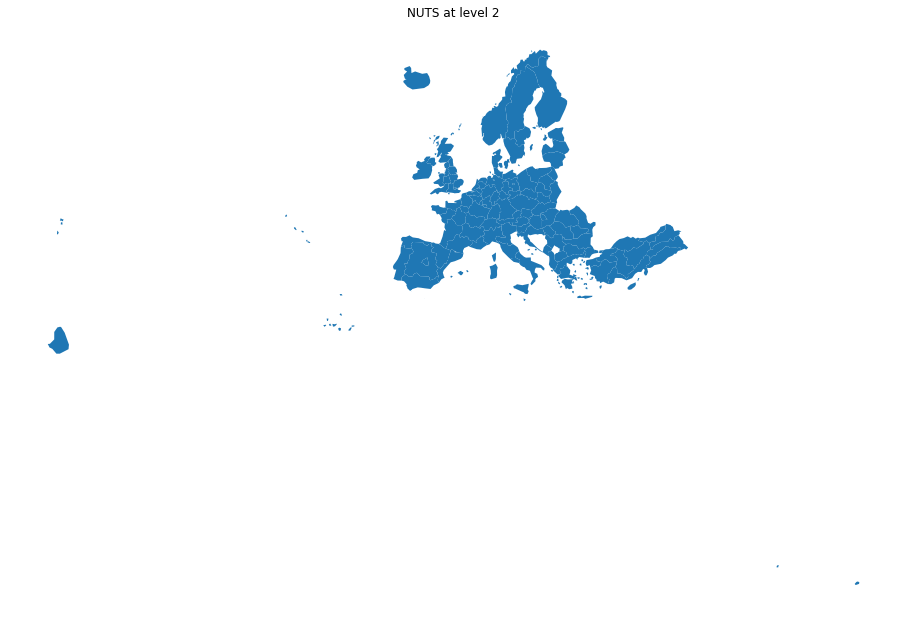

In [16]:
f, ax = mplt.subplots(1, figsize=(16, 16))
nuts_data[levels[0]].plot(ax=ax)
ax.set_axis_off()
ax.set_title('NUTS at level %s' % levels[1])
mplt.show()

### Data representation

Let's select a year of interest for comparison. All data collected before that data will be discarded:

In [17]:
YSTART = 2017
try:
    assert YSTART in YEARS
except:
    raise IOError("Select another start year in \033[1m%s\033[0m" % YEARS)
else:
    CYEARS, RYEARS = range(YSTART,max(YEARS)), range(YSTART,max(YEARS)+1)
DISCARD_COLS = [col for col in NUM_COLS if int(col.split('W')[0])<YSTART]
COLUMNS = [col for col in death_data.columns if not re.search('W', col) or int(col.split('W')[0])>=YSTART]
NUM_COLS = list(set(NUM_COLS).difference(set(DISCARD_COLS)))
if len(DISCARD_COLS) < len(COLUMNS):
    death_data.drop(columns=DISCARD_COLS, inplace=True)
else:
    death_data = death_data[COLUMNS]
print("Updated list of variables considered for this analysis: \033[1m%s\033[0m" % list(death_data.columns))

Updated list of variables considered for this analysis: ['2020W18', '2020W17', '2020W16', '2020W15', '2020W14', '2020W13', '2020W12', '2020W11', '2020W10', '2020W09', '2020W08', '2020W07', '2020W06', '2020W05', '2020W04', '2020W03', '2020W02', '2020W01', '2019W52', '2019W51', '2019W50', '2019W49', '2019W48', '2019W47', '2019W46', '2019W45', '2019W44', '2019W43', '2019W42', '2019W41', '2019W40', '2019W39', '2019W38', '2019W37', '2019W36', '2019W35', '2019W34', '2019W33', '2019W32', '2019W31', '2019W30', '2019W29', '2019W28', '2019W27', '2019W26', '2019W25', '2019W24', '2019W23', '2019W22', '2019W21', '2019W20', '2019W19', '2019W18', '2019W17', '2019W16', '2019W15', '2019W14', '2019W13', '2019W12', '2019W11', '2019W10', '2019W09', '2019W08', '2019W07', '2019W06', '2019W05', '2019W04', '2019W03', '2019W02', '2019W01', '2018W52', '2018W51', '2018W50', '2018W49', '2018W48', '2018W47', '2018W46', '2018W45', '2018W44', '2018W43', '2018W42', '2018W41', '2018W40', '2018W39', '2018W38', '2018W37

Let's select a specific period of interest:

In [18]:
DATE, WEEK = None, list(range(9,16)) # select what you are interested
if WEEK is None:
    try:
        WEEK = DATE.isocalendar()[1]
    except:
        WEEK = [15]
BASE = "mean" # "max" # "min"

We can then easily compute the excess rate of deaths over a (couple of) weeks in the current year with respect to the ("mean","max","min") of deaths over the previous years:

In [19]:
def excess_rate(data, week, agg="mean", ystart=YSTART, year=YCUR):
    if np.isscalar(week): 
        week = [week,]
    years = range(ystart, YCUR)
    cols = [col for col in data.columns                               \
            if any([col.strip().endswith('W%02d' % w) for w in week]) \
            and int(col.split('W')[0]) in years]
    sagg = data[cols].agg(agg, axis='columns', skipna=False) # we cant ignore missing values!
    if len(week)>1:
        cols = [col for col in data.columns                               \
                if any([col.strip().endswith('W%02d' % w) for w in week]) \
                and col.startswith('%sW' % str(year))]
        syear = data[cols].mean(axis='columns', skipna=False) # take the mean 
    else:
        syear = data['%sW%02d' % (str(year),week[0])]
    data['rinc'] = 100 * syear.sub(sagg).div(sagg)
    return data

death_data = excess_rate(death_data, WEEK, agg=BASE)

w_death_data = death_data.drop(columns=[col for col in NUM_COLS if int(col.split('W')[1]) not in WEEK])
w_death_data.head(10)

,2020W15,2020W14,2020W13,2020W12,2020W11,2020W10,2020W09,2019W15,2019W14,2019W13,...,2017W13,2017W12,2017W11,2017W10,2017W09,unit,sex,age,geo,rinc
0,NaN,NaN,191.0,265.0,268.0,285.0,331.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NR,F,TOTAL,AM,NaN
1,NaN,NaN,893.0,926.0,854.0,881.0,905.0,837.0,830.0,835.0,...,790.0,819.0,826.0,860.0,917.0,NR,F,TOTAL,AT,NaN
2,NaN,NaN,399.0,411.0,375.0,386.0,390.0,372.0,367.0,361.0,...,383.0,387.0,386.0,394.0,416.0,NR,F,TOTAL,AT1,NaN
3,NaN,NaN,46.0,37.0,28.0,46.0,36.0,24.0,42.0,24.0,...,30.0,22.0,34.0,29.0,38.0,NR,F,TOTAL,AT11,NaN
4,NaN,NaN,158.0,180.0,172.0,183.0,180.0,196.0,180.0,173.0,...,170.0,174.0,198.0,193.0,175.0,NR,F,TOTAL,AT12,NaN
5,NaN,NaN,195.0,194.0,175.0,157.0,174.0,152.0,145.0,164.0,...,183.0,191.0,154.0,172.0,203.0,NR,F,TOTAL,AT13,NaN
6,NaN,NaN,208.0,220.0,201.0,212.0,217.0,187.0,192.0,181.0,...,162.0,190.0,181.0,185.0,194.0,NR,F,TOTAL,AT2,NaN
7,NaN,NaN,71.0,63.0,70.0,62.0,62.0,64.0,70.0,54.0,...,54.0,53.0,55.0,55.0,60.0,NR,F,TOTAL,AT21,NaN
8,NaN,NaN,137.0,157.0,131.0,150.0,155.0,123.0,122.0,127.0,...,108.0,137.0,126.0,130.0,134.0,NR,F,TOTAL,AT22,NaN
9,NaN,NaN,286.0,295.0,278.0,283.0,298.0,278.0,271.0,293.0,...,245.0,242.0,259.0,281.0,307.0,NR,F,TOTAL,AT3,NaN


In [20]:
def time_series(data, geo, age="TOTAL", sex="T"):
    if geo not in REGIONS:
        return
    ts = pd.DataFrame(columns=[y for y in RYEARS], index=pd.Index(WEEKS))
    extract = data.loc[(data["geo"]==geo) & (data["age"]==age) & (data["sex"]==sex)]
    extract = extract.drop(columns=[col for col in data.columns if col not in NUM_COLS])
    for y in RYEARS:
        ts[y] = pd.Series(extract[["%sW%02d" % (y,w) for w in WEEKS]].values[0])
    return ts

REG = "AT12"
AGE, SEX = "TOTAL", "T"
ts = time_series(death_data, REG, age=AGE, sex=SEX)
try: 
    assert ts is not None
except:
    print("\033[1m!!! No data available for the considered region !!!\033[0m")
ts is not None and ts.head(10)

,2017,2018,2019,2020
1,517.0,365.0,330.0,390.0
2,431.0,366.0,342.0,393.0
3,346.0,356.0,377.0,383.0
4,424.0,399.0,380.0,394.0
5,392.0,404.0,340.0,338.0
6,372.0,367.0,385.0,342.0
7,393.0,435.0,373.0,353.0
8,323.0,419.0,336.0,363.0
9,351.0,428.0,366.0,381.0
10,349.0,444.0,372.0,365.0


In [21]:
def plot_oneversus(dat, index = None, one = None, versus = None,  
                   fig=None, ax=None, shp = (1,1), dpi=_DPI_,
                   xlabel='', ylabel='', title = '', xrottick = False, legend = None,                 
                   grid = False, suptitle = '', locator = None, formatter = None):    
    if ax is None:
        if shp in (None,[],()): shp = (1,1)
        if dpi is None:     fig, pax = mplt.subplots(*shp, constrained_layout=True)
        else:               fig, pax = mplt.subplots(*shp, dpi=dpi, constrained_layout=True)
        if isinstance(pax,np.ndarray):
            if pax.ndim == 1:    ax_ = pax[0]
            else:               ax_ = pax[0,0]
        else:
            ax_ = pax
    else:
        ax_, pax = ax, None
    if index is None:
        index = dat.index
    if one is not None:
        ax_.plot(dat.loc[index,one], ls='-', lw=0.6, c='r', 
                 marker='v', markersize=6, fillstyle='none')
        next(ax_._get_lines.prop_cycler)
    if versus is None:
        versus = dat.columns
        try:    versus.remote(one)
        except: pass
    ax_.plot(dat.loc[index,versus], ls='None', marker='o', fillstyle='none')
    ax_.set_xlabel(xlabel), ax_.set_ylabel(ylabel)
    if grid is not False:       ax_.grid(linewidth=grid)
    if xrottick is not False:   ax_.tick_params(axis ='x', labelrotation=xrottick)
    if locator is not None:     ax_.xaxis.set_major_locator(locator)
    if formatter is not None:   ax_.xaxis.set_major_formatter(formatter)
    if legend is None:
        legend = [one]
        legend.extend(versus)
    ax_.legend(legend, fontsize='small')
    if title not in ('',None):  ax_.set_title(title,  fontsize='medium')
    if suptitle not in ('',None):       
        fig.suptitle(suptitle,  fontsize='medium')
    if pax is not None:
        return fig, pax

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b83f510>)

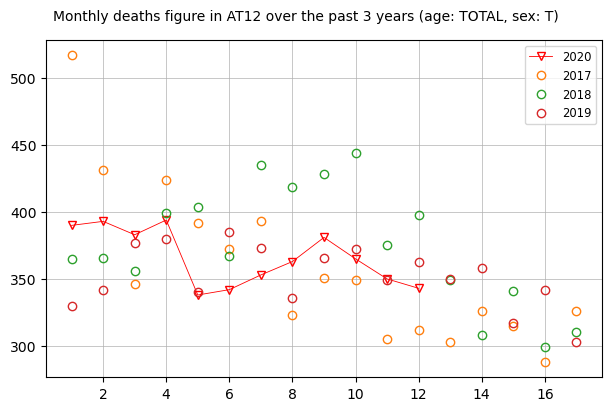

In [22]:
plot_oneversus(ts,index=WEEKS, one=YCUR, versus=CYEARS, dpi=100, grid = 0.5,
               suptitle="Monthly deaths figure in %s over the past %s years (age: %s, sex: %s)" 
                       % (REG,max(RYEARS)-min(RYEARS),AGE,SEX)
              )

Let's consider the entire population for the specific period:

In [23]:
AGE, SEX = "TOTAL", "T"

s_death_data = death_data.loc[(death_data["age"]==AGE) & (death_data["sex"]==SEX)]
# col_drop = [col for col in NUM_COLS if re.search('W',col) is not None and WEEKS.count(int(col.split('W')[1])) == 0]
col_drop = list(set(s_death_data.columns).difference(set(['geo','rinc'])))
s_death_data.drop(columns=col_drop, inplace=True)

s_death_data.dropna(axis='index', subset=['rinc'], inplace=True)

s_death_data.head(10)

/Library/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Library/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,geo,rinc
19268,BE,27.928935
19269,BE1,65.330189
19270,BE10,65.330189
19271,BE100,65.330189
19272,BE2,20.904157
19273,BE21,13.648807
19274,BE211,9.385039
19275,BE212,15.833333
19276,BE213,21.890016
19277,BE22,46.324589


In [24]:
s_death_data.rename(columns={'geo':'NUTS_ID'}, inplace=True)

for l in levels:
    nuts_data[l] = nuts_data[l].merge(s_death_data, on='NUTS_ID').dropna(axis='index', subset=['rinc'])
nuts_data[3].head()

/Library/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,COAST_TYPE,MOUNT_TYPE,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry,rinc
0,BE100,3,4,BE,BE100,BE100,Arr. de Bruxelles-Capitale/Arr. van Brussel-Ho...,3,1,"POLYGON ((3915050.000 3094470.000, 3919591.000...",65.330189
1,BE211,1,4,BE,BE211,BE211,Arr. Antwerpen,3,1,"POLYGON ((3950379.000 3132049.000, 3922957.000...",9.385039
2,BE212,2,4,BE,BE212,BE212,Arr. Mechelen,3,1,"POLYGON ((3955879.000 3116089.000, 3937267.000...",15.833333
3,BE213,3,4,BE,BE213,BE213,Arr. Turnhout,3,2,"POLYGON ((3980659.000 3157888.000, 3988851.000...",21.890016
4,BE221,3,4,BE,BE221,BE221,Arr. Hasselt,3,1,"POLYGON ((4013903.000 3107852.000, 3984947.000...",49.578888


Assuming that when a region `A` is available at level `l`, all the regions belonging to the same region at level `l-1` than `A` are also available at level `l`, we represent only the finest regions:

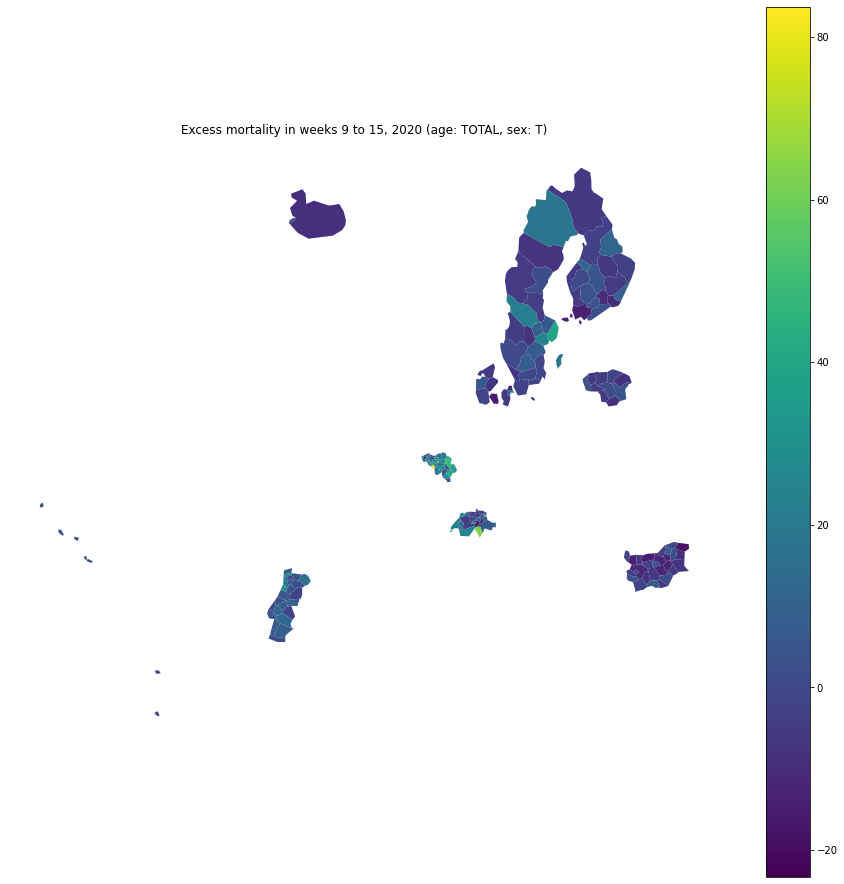

In [25]:
f, ax = mplt.subplots(1, figsize=(16, 16))
nuts_data[3].plot(column='rinc', legend=True, ax=ax)
ax.set_axis_off()
ax.set_title('Excess mortality in weeks %s to %s, %s (age: %s, sex: %s)' % (min(WEEK), max(WEEK), YCUR, AGE, SEX))
mplt.show()

In [27]:
OKREGIONS = s_death_data['NUTS_ID'].unique().tolist()
print("NUTS regions actually available for this selection: \033[1m%s\033[0m" % OKREGIONS)

NUTS regions actually available for this selection: ['BE', 'BE1', 'BE10', 'BE100', 'BE2', 'BE21', 'BE211', 'BE212', 'BE213', 'BE22', 'BE221', 'BE222', 'BE223', 'BE23', 'BE231', 'BE232', 'BE233', 'BE234', 'BE235', 'BE236', 'BE24', 'BE241', 'BE242', 'BE25', 'BE251', 'BE252', 'BE253', 'BE254', 'BE255', 'BE256', 'BE257', 'BE258', 'BE3', 'BE31', 'BE310', 'BE32', 'BE321', 'BE322', 'BE323', 'BE324', 'BE325', 'BE326', 'BE327', 'BE33', 'BE331', 'BE332', 'BE334', 'BE335', 'BE336', 'BE34', 'BE341', 'BE342', 'BE343', 'BE344', 'BE345', 'BE35', 'BE351', 'BE352', 'BE353', 'BG', 'BG3', 'BG31', 'BG311', 'BG312', 'BG313', 'BG314', 'BG315', 'BG32', 'BG321', 'BG322', 'BG323', 'BG324', 'BG325', 'BG33', 'BG331', 'BG332', 'BG333', 'BG334', 'BG34', 'BG341', 'BG342', 'BG343', 'BG344', 'BG4', 'BG41', 'BG411', 'BG412', 'BG413', 'BG414', 'BG415', 'BG42', 'BG421', 'BG422', 'BG423', 'BG424', 'BG425', 'CH', 'CH01', 'CH011', 'CH012', 'CH013', 'CH02', 'CH021', 'CH022', 'CH023', 'CH024', 'CH025', 'CH03', 'CH031', 'CH03